In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Currently there is a 5 day limit on runtime for GPU jobs, although some users have been asking for extensions. What is the distribution of requested runtime and actual runtime on jobs on each partition? Do users really need more time, or are they simply always requesting the maximum?

Import Dataframe

In [2]:
raw = pd.read_csv('../data/accre-gpu-jobs-2022-v2.csv',
                 on_bad_lines='warn',
                 engine='python') 

Skipping line 124084: Expected 12 fields in line 124084, saw 13
Skipping line 124809: Expected 12 fields in line 124809, saw 13


In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336950 entries, 0 to 336949
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   JOBID      336950 non-null  object
 1   ACCOUNT    336950 non-null  object
 2   USER       336950 non-null  object
 3   USEDMEM    336950 non-null  object
 4   REQTIME    336950 non-null  object
 5   USEDTIME   336950 non-null  object
 6   NODES      336950 non-null  int64 
 7   CPUS       336950 non-null  int64 
 8   GPUS       336950 non-null  int64 
 9   PARTITION  336950 non-null  object
 10  EXITCODE   336950 non-null  object
 11  STATE      336950 non-null  object
dtypes: int64(3), object(9)
memory usage: 30.8+ MB


In [4]:
# Use .copy when subsetting!!!!
com_job=raw[raw["STATE"] == 'COMPLETED'].copy()
com_job

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE
0,32880657,malanga,arline,18.66M,2-00:00:00,00:13:13,1,2,1,pascal,0:0,COMPLETED
1,32880701,glasshouse,brady,0,05:00:00,00:00:22,1,3,1,maxwell,0:0,COMPLETED
2,32880718,glasshouse,brady,402.32M,05:00:00,00:08:57,1,3,1,maxwell,0:0,COMPLETED
3,32880719,glasshouse,brady,417.62M,20:00:00,05:09:46,1,1,1,pascal,0:0,COMPLETED
4,32880720,glasshouse,brady,450.09M,15:00:00,04:11:10,1,1,1,pascal,0:0,COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...
336933,46753813,harovin,shannon,137.96M,5-00:00:00,00:00:52,1,1,1,turing,0:0,COMPLETED
336934,46753820_26,harovin,porsha,5093.70M,5-00:00:00,00:34:51,1,6,1,turing,0:0,COMPLETED
336936,46753823,harovin,shannon,156.21M,5-00:00:00,00:04:03,1,1,1,turing,0:0,COMPLETED
336942,46754095,harovin,shannon,2820.52M,5-00:00:00,00:11:13,1,1,1,turing,0:0,COMPLETED


1. What is the distribution of per-GPU main memory usage over all runtime-weighed jobs in each partition? Knowing this will help ACCRE to understand our users memory needs for future hardware purchases.

In [5]:
#Stripping, cleaning, and type changing USEDMEM
com_job['USEDMEM'] = com_job['USEDMEM'].str.replace('M', '').astype(float)
#Stripping, cleaning, and type changing, and refactoring REQTIME
com_job['REQTIME'] = pd.to_timedelta(com_job['REQTIME'].str.replace('-',' days ')).dt.total_seconds()
#Calculated column for hours of requested time (Credit to team TWIX)
com_job["req_time_hours"] = com_job["REQTIME"]/3600
#Stripping, cleaning, and type changing, and refactoring USEDTIME
com_job['USEDTIME'] = pd.to_timedelta(com_job['USEDTIME'].str.replace('-',' days ')).dt.total_seconds()
#Calculated column for hours of used time (Credit to team TWIX)
com_job["used_time_hours"] = com_job["USEDTIME"]/3600
#Calculated column for ratio of used time and requested time(percent of time used of requested)
com_job["req_used_ratio"] = ((com_job['USEDTIME'] / com_job['REQTIME']))
#Calculated column for difference in requested time and used time in seconds
com_job["req_dif_sec"] = ((com_job['REQTIME'] - com_job['USEDTIME']))
#Calculated column for difference in requested and used time in hours
com_job["req_dif_hour"] = (com_job["REQTIME"] - com_job["USEDTIME"])/3600
com_job['GPUS'] = com_job['GPUS'].astype(str).str.zfill(2)
#Changing datatypes of columns (maybe very unnessisary)
#com_job['CPUS'] = com_job['CPUS'].astype(str)
#com_job['GPUS'] = com_job['GPUS'].astype(str)

In [6]:
# Would it be useful for the scheduler to know the difference between requested and used time.
# Would it be useful to know the distribution of the ratio of requested vs. used time for specific users
com_job.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283333 entries, 0 to 336948
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   JOBID            283333 non-null  object 
 1   ACCOUNT          283333 non-null  object 
 2   USER             283333 non-null  object 
 3   USEDMEM          283333 non-null  float64
 4   REQTIME          283333 non-null  float64
 5   USEDTIME         283333 non-null  float64
 6   NODES            283333 non-null  int64  
 7   CPUS             283333 non-null  int64  
 8   GPUS             283333 non-null  object 
 9   PARTITION        283333 non-null  object 
 10  EXITCODE         283333 non-null  object 
 11  STATE            283333 non-null  object 
 12  req_time_hours   283333 non-null  float64
 13  used_time_hours  283333 non-null  float64
 14  req_used_ratio   283333 non-null  float64
 15  req_dif_sec      283333 non-null  float64
 16  req_dif_hour     283333 non-null  floa

In [7]:
com_job.head(n=1)

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,req_time_hours,used_time_hours,req_used_ratio,req_dif_sec,req_dif_hour
0,32880657,malanga,arline,18.66,172800.0,793.0,1,2,01,pascal,0:0,COMPLETED,48.0,0.220278,0.004589,172007.0,47.779722


In [23]:
#Count of all jobs by account across all Partitions.
com_job['ACCOUNT'].value_counts().sort_index()

almonds             189
antares            3203
apple                45
bertanne            195
bunch                 1
cactus              113
clara                76
gem                  19
glasshouse       237060
grisette           5786
harovin            4729
horseradish          48
kinnow              380
malanga            9901
orange               74
packham               7
pasilla            1329
pecans              609
pinole               19
plumcot            1027
prince             7459
rosemarie            55
sugranineteen        31
summer                1
sunburst           1390
virginia           9556
white                31
Name: ACCOUNT, dtype: int64

In [24]:
#unique partitions
com_job['PARTITION'].unique()

array(['pascal', 'maxwell', 'turing'], dtype=object)

In [10]:
# Overall distribution of the percent of actual time used vs. requested time.
# Across all partitions, the average user utiliezed 5.5% of the time that they requested
#IQR - 0.013329.  At-least half of all users only utilize 1.3% percent of the times they request.

com_job["req_used_ratio"].describe()


count    283333.000000
mean          0.054817
std           0.154017
min           0.000000
25%           0.001139
50%           0.005472
75%           0.014468
max           1.934722
Name: req_used_ratio, dtype: float64

In [11]:
#Distribution of percent of actual time used vs. requested time
com_job.groupby('PARTITION')['req_used_ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
PARTITION,,,,,,,,
maxwell,127043.0,0.017691,0.088038,0.0,0.000278,0.005000,0.006222,1.100000
pascal,81314.0,0.088328,0.215047,0.0,0.001275,0.004921,0.018819,1.483333
turing,74976.0,0.081381,0.148649,0.0,0.003611,0.027500,0.108889,1.934722


- maxwell 
    - average  use use/request ratio of 1.8% (0.017691)
    - 50% of maxwell users utilize 6% (IQR = 0.005944) of the time that they requested
- pascal
    - average  use use/request ratio of 8.8% (0.088328) of the requested time
    - 50% of pascal users utilize 1.8% (IQR = 0.017544) of the time that they requested
- turing 
    - average  use use/request ratio of 8.1% (0.081381)of the requested time
    - 50% of pascal users utilize 1.8% (IQR = 0.017544) of the time that they requested

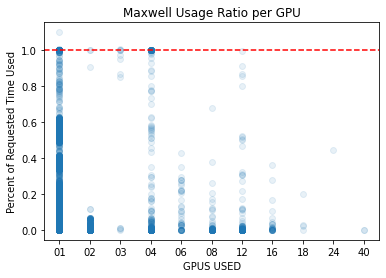

In [28]:
#USAGE RATIO OF GPUS Across Maxwell Partition
plot_df = com_job.loc[com_job['PARTITION'] == 'maxwell'].sort_values('GPUS')
plt.scatter(plot_df['GPUS'], plot_df["req_used_ratio"], alpha = 0.1)
plt.xlabel("GPUS USED")
plt.ylabel("Percent of Requested Time Used")
plt.title("Maxwell Usage Ratio per GPU")
plt.axhline(y=1, color='r', linestyle='--')

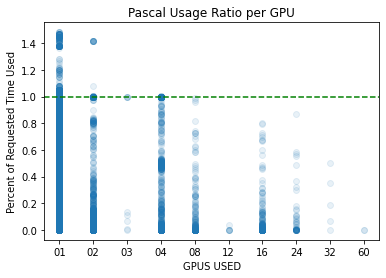

In [30]:
#USAGE RATIO OF GPUS Across Pascal Partition
plot_df = com_job.loc[com_job['PARTITION'] == 'pascal'].sort_values('GPUS')
plt.scatter(plot_df['GPUS'], plot_df["req_used_ratio"], alpha = 0.1)
plt.xlabel("GPUS USED")
plt.ylabel("Percent of Requested Time Used")
plt.title("Pascal Usage Ratio per GPU")
plt.axhline(y=1, color='g', linestyle='--')

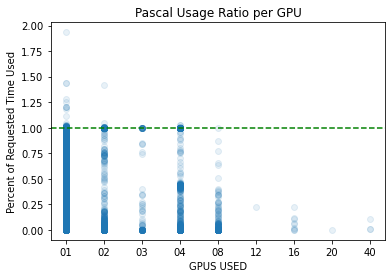

In [33]:
#USAGE RATIO OF GPUS Across Turing Partition
plot_df = com_job.loc[com_job['PARTITION'] == 'turing'].sort_values('GPUS')
plt.scatter(plot_df['GPUS'], plot_df["req_used_ratio"], alpha = 0.1)
plt.xlabel("GPUS USED")
plt.ylabel("Percent of Requested Time Used")
plt.title("Turing Usage Ratio per GPU")
plt.axhline(y=1, color='g', linestyle='--')

In [35]:
#Distribution of usage ratio for GPUS across all partitions.
com_job.groupby('GPUS')['req_used_ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
GPUS,,,,,,,,
01,274861.0,0.052625,0.148062,0.000000,0.001139,0.005444,0.013488,1.934722
02,5470.0,0.072503,0.210354,0.000005,0.002283,0.008532,0.027506,1.418015
03,107.0,0.336250,0.429452,0.000019,0.000405,0.051076,0.860057,1.004028
04,1831.0,0.301966,0.391386,0.000000,0.000557,0.028935,0.507711,1.029167
06,44.0,0.106673,0.118232,0.000017,0.001205,0.042514,0.217052,0.426681
08,517.0,0.078108,0.171366,0.000000,0.000028,0.001460,0.059025,1.000017
12,165.0,0.061489,0.179146,0.000000,0.000019,0.000056,0.011108,0.996840
16,276.0,0.068949,0.150855,0.000007,0.000183,0.007300,0.047096,0.804269
18,4.0,0.064014,0.092566,0.001722,0.018660,0.026292,0.071646,0.201750
